In [57]:
# Import Libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions import *
%matplotlib inline

## Load Datasets from CSV Files

In [58]:
# Read CSV files containing sales transactions and temperatures
pathfile = './datasets/'
data_years = ['2018', '2019', '2020', '2021']


# Load datasets with sales between 2014 and 2019
filename = 'y_'
df_sales = pd.read_csv(pathfile + filename + '2017.csv', infer_datetime_format = True, encoding = 'latin-1')
print('Initiall Shape df_sales: {}, year: 2017'.format(df_sales.shape) )

for year in data_years:
    df = pd.read_csv(pathfile + filename + year + '.csv', infer_datetime_format = True, encoding = 'latin-1')
    df_sales = pd.concat([df_sales, df], ignore_index=True)
    print('Shapes df: {}, df_sales: {}, year: {}'.format(df.shape, df_sales.shape, year) )

# Read dataset with Minimum Phoenix Temperatures
df_min_temp = pd.read_csv(pathfile + 'phx_min_temp.csv', sep='\t', encoding = 'utf-8')

# Read dataset with Maximum Phoenix Temperatures
df_max_temp = pd.read_csv(pathfile + 'phx_max_temp.csv', sep='\t', encoding = 'utf-8')

df_tmp = None

Initiall Shape df_sales: (25030, 11), year: 2017
Shapes df: (27331, 11), df_sales: (52361, 11), year: 2018
Shapes df: (27993, 11), df_sales: (80354, 11), year: 2019
Shapes df: (26658, 11), df_sales: (107012, 11), year: 2020
Shapes df: (9495, 11), df_sales: (116507, 11), year: 2021


In [59]:
df_sales.head()

,Unnamed: 0,Type,Date,Num,Memo,Name,Item,Qty,Sales Price,Amount,Balance
0,Inventory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00-Beer & Spirits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"00177USA - R2 Casino Azul Blanc (Casino Azul, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Invoice,01/18/2017,70229,"Casino Azul, Tequila Blanco",Total Wine 1006,00-Beer & Spirits:00177USA - R2 Casino Azul Bl...,6.0,29.95,179.7,179.7
4,NaN,Invoice,01/18/2017,70233,"Casino Azul, Tequila Blanco",Total Wine 1004,00-Beer & Spirits:00177USA - R2 Casino Azul Bl...,6.0,29.95,179.7,359.4


## Data Preprocessing

In [60]:
# Dictionary with interesting Products for the project
target_items = {'60190':'Dipinti, Pinot Grigio La Vis',
                '20209':'Alverdi, Pinot Grigio',
                '70165':'Santome, Prosecco Extra Dry',
                '50215':'Carpineto, Dogajolo Rosso',
                '70208':'Italo Cescon, Pinot Grigio',
                '70271':'Le Contesse, Pinot Noir Rose Brut'
               }
df_sales = clean_sales(df_sales, list(target_items.keys()))
df_sales.head()

Final Dataset Shape: (8048, 5)


,quantity,price,item_code,month,year
5623,7.0,6.99,20209,1,2017
5624,12.0,6.99,20209,1,2017
5625,12.0,6.99,20209,1,2017
5626,12.0,6.99,20209,1,2017
5627,6.0,6.99,20209,1,2017


Check for NaN's Values

In [61]:
print('Null values:\n{}'.format(df_sales.isnull().sum())) # Display Null values per Column
print(df_sales[df_sales['price'].isnull()]) # Display rows with Null values

Null values:
quantity     0
price        1
item_code    0
month        0
year         0
dtype: int64
        quantity  price item_code  month  year
100379       2.0    NaN     70271      5  2020


Imputate average price for 1 row with Nan value

In [62]:
df_sales.loc[100379,'price'] = df_sales.price[df_sales['item_code']=='70271'].mean()
print('Null values:\n{}'.format(df_sales.isnull().sum())) # Display Null values per Column

Null values:
quantity     0
price        0
item_code    0
month        0
year         0
dtype: int64


Create Time Series for each product by Month

In [63]:
df = df_sales.groupby(by=['item_code','year','month'], as_index=False).agg(
    quantity=('quantity','sum'), 
    avg_price=('price', np.mean)
) # Group by item, month and year to result in a time series for each product
df['day'] = "01"
df['date'] = pd.to_datetime(df[['year','month','day']]) # Create a date column using year, month and day
df.drop(['month','day','year'], axis=1, inplace=True) # Drop day, month and year columns
df.head()

,item_code,quantity,avg_price,date
0,20209,109.0,6.990000,2017-01-01
1,20209,136.0,7.144666,2017-02-01
2,20209,129.0,6.990000,2017-03-01
3,20209,190.0,6.990000,2017-04-01
4,20209,172.0,6.990000,2017-05-01


Check the number of Data Points per Item

In [64]:
for item, values in target_items.items():
    print('Item: {}, Data Points:{}, {}'.format(item, df.date[df['item_code']==item].count(), values))

Item: 60190, Data Points:37, Dipinti, Pinot Grigio La Vis
Item: 20209, Data Points:52, Alverdi, Pinot Grigio
Item: 70165, Data Points:52, Santome, Prosecco Extra Dry
Item: 50215, Data Points:52, Carpineto, Dogajolo Rosso
Item: 70208, Data Points:52, Italo Cescon, Pinot Grigio
Item: 70271, Data Points:43, Le Contesse, Pinot Noir Rose Brut


In [65]:
# Remove rows with date ='2021-04-01' since April 2021 data is incomplete
df.drop(df[df['date'] == '2021-04-01'].index, axis=0, inplace = True)
df.shape

(282, 4)

## Additional Features

The next section adds 2 new features to dataset:
- Phoenix Minimum Temperatures
- Phoenix Maximum Temperatures
- Log of 'quantity'

In [66]:
# Perform cleanning and formatting to temperature datasets
df_min_temp_transformed = extract_temperature(df_min_temp, new_colum_name='min_temp')
df_max_temp_transformed = extract_temperature(df_max_temp, new_colum_name='max_temp')
print('Shapes: Min Temp: {}, Max Temp:{}'.format(df_min_temp_transformed.shape, df_max_temp_transformed.shape))

Shapes: Min Temp: (84, 2), Max Temp:(84, 2)


In [67]:
# Perform a inner join between transformed temperatures datasets
df_transformed = pd.merge(df_min_temp_transformed,
                          df_max_temp_transformed,
                          how='inner',
                          on='date'                          
                         )
print(f'Shape: {df_transformed.shape}')

Shape: (84, 3)


In [68]:
df = pd.merge(df,
              df_transformed,
              how='inner',
              on='date'
             )
print(f'Shape: {df.shape}')

Shape: (282, 6)


In [69]:
df['log_quantity'] = np.log(df.quantity + 1e-8)

In [70]:
# Filter datapoint to be used
# Here I'm looking for the most recent 36 observations

# num_data_point = 36
# df = df[df['date']>='2018-04-01']
# print(f'Shape: {df.shape}')
# print(f'Expected Shape:{(len(target_items)*num_data_point)}')

In [71]:
# Print number of observations by Product

for item, values in target_items.items():
    print('Item: {}, Data Points:{}, {}'.format(item, df.date[df['item_code']==item].count(), values))

Item: 60190, Data Points:36, Dipinti, Pinot Grigio La Vis
Item: 20209, Data Points:51, Alverdi, Pinot Grigio
Item: 70165, Data Points:51, Santome, Prosecco Extra Dry
Item: 50215, Data Points:51, Carpineto, Dogajolo Rosso
Item: 70208, Data Points:51, Italo Cescon, Pinot Grigio
Item: 70271, Data Points:42, Le Contesse, Pinot Noir Rose Brut


## Final dataset

Feature Description:

"item_code": Code reference uses to identify the product</br>
"quantity": Indicate the number of bottle sold for the corresponding month</br>
"avg_price": Average price of the product for the indicated month</br>
"date": Monthly date to denotate time series sequence</br>
"min_temp": Reflect the minimum temperatures measured in Phoenix Arizona during the month</br>
"max_temp": Reflect the maximum temperatures measured in Phoenix Arizona during the month</br>

In [72]:
df.head()

,item_code,quantity,avg_price,date,min_temp,max_temp,log_quantity
0,20209,109.0,6.990000,2017-01-01,35,76,4.691348
1,50215,422.0,9.845294,2017-01-01,35,76,6.045005
2,70165,471.0,9.458725,2017-01-01,35,76,6.154858
3,70208,145.0,10.067692,2017-01-01,35,76,4.976734
4,20209,136.0,7.144666,2017-02-01,42,83,4.912655


## Visualization by Product

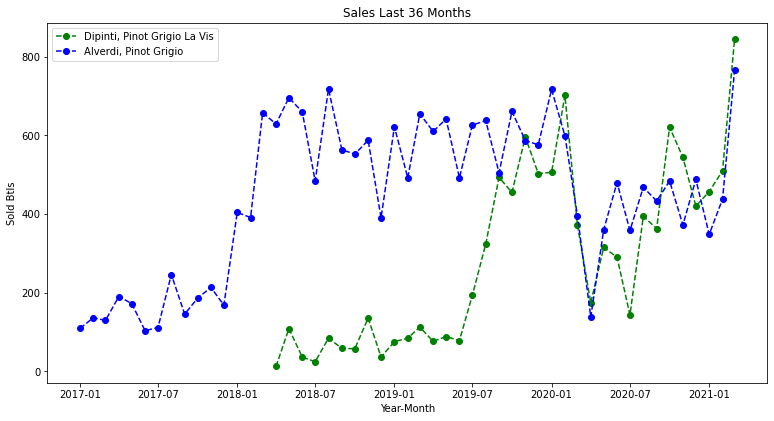

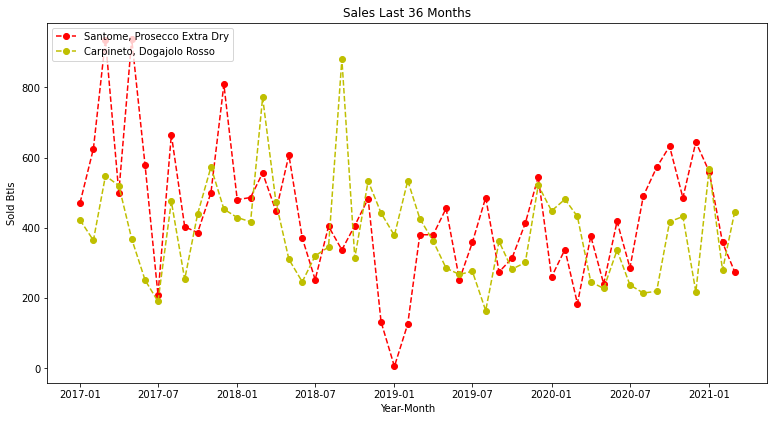

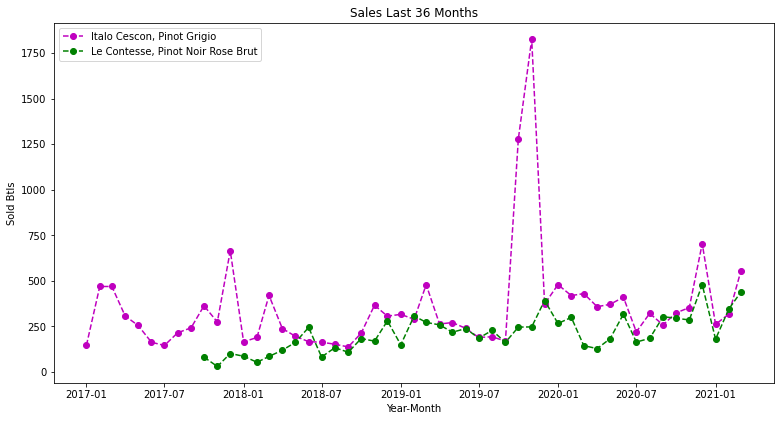

In [73]:
# Create 
plot_item(df, list(target_items.keys())[0:2], list(target_items.values())[0:2], ['go--','bo--'] )
plot_item(df, list(target_items.keys())[2:4], list(target_items.values())[2:4], ['ro--','yo--'] )
plot_item(df, list(target_items.keys())[4:6], list(target_items.values())[4:6], ['mo--','go--'] )

## Simple Moving Average Benchmark

In [39]:
# df = df.set_index('date')

In [74]:
for item, val in target_items.items():
    print(item, val)

60190 Dipinti, Pinot Grigio La Vis
20209 Alverdi, Pinot Grigio
70165 Santome, Prosecco Extra Dry
50215 Carpineto, Dogajolo Rosso
70208 Italo Cescon, Pinot Grigio
70271 Le Contesse, Pinot Noir Rose Brut


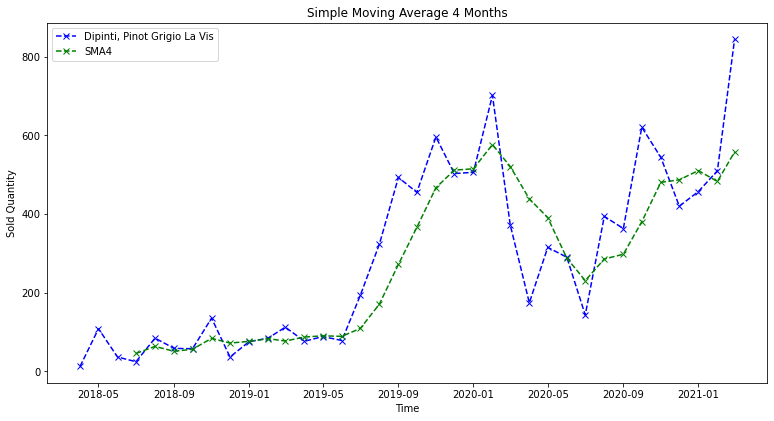

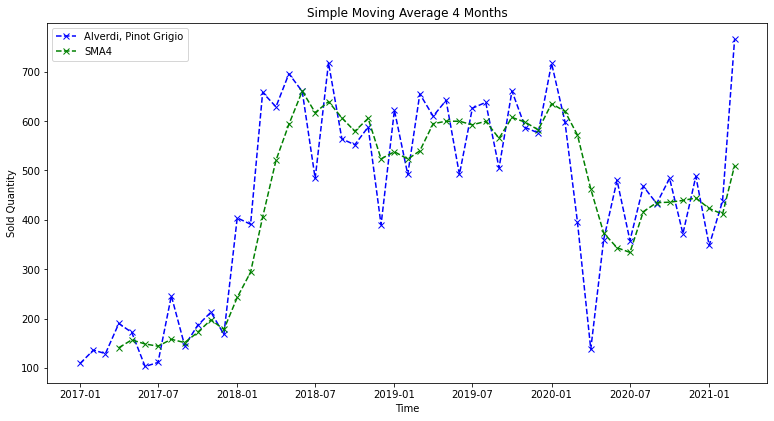

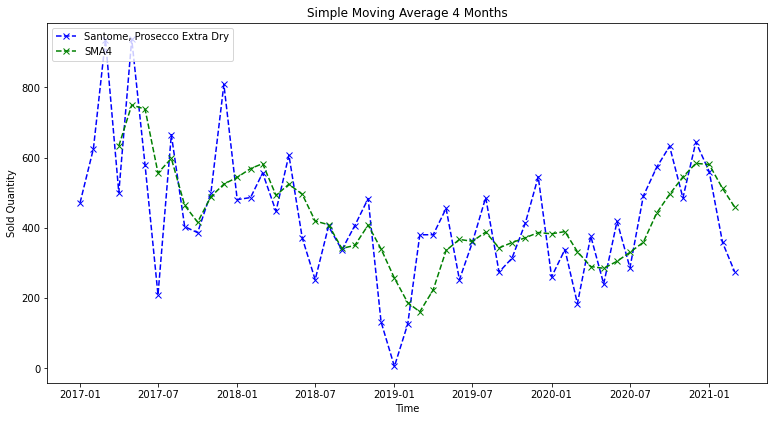

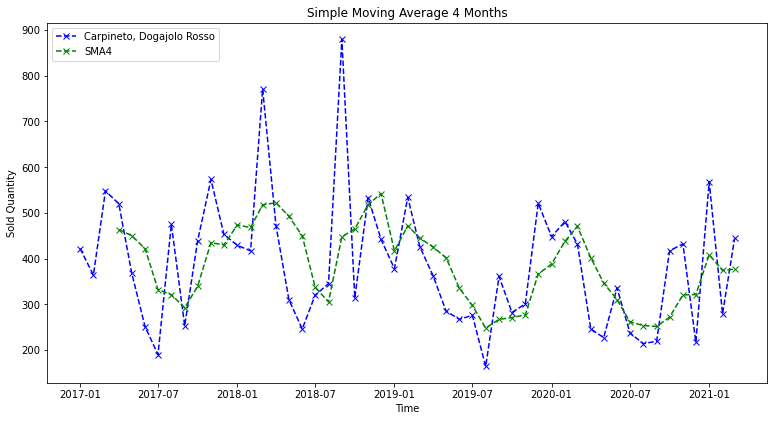

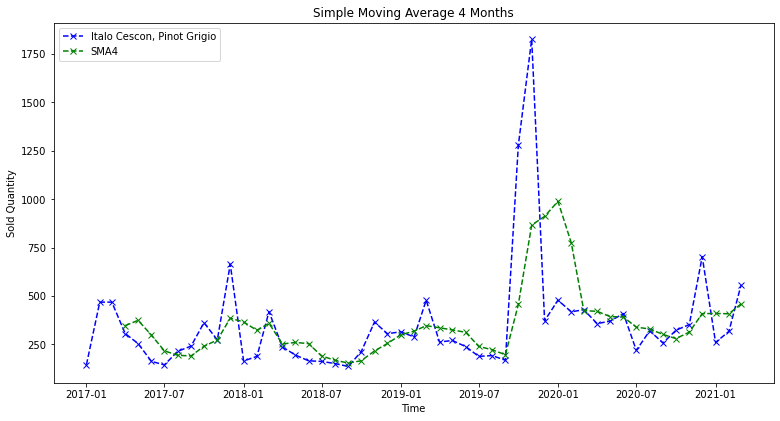

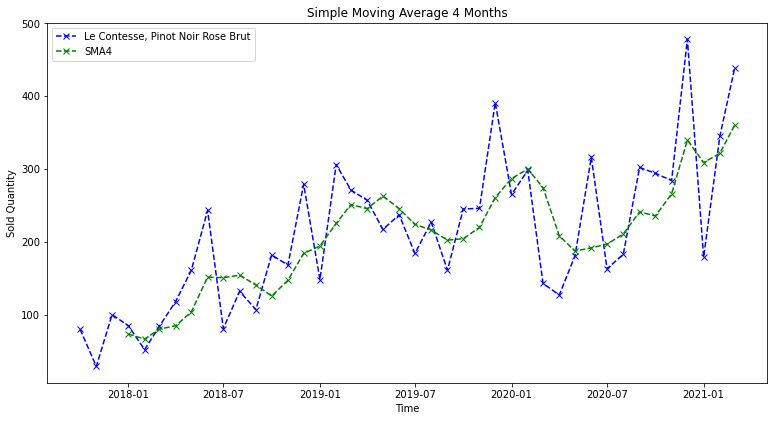

In [86]:
# 20209 Alverdi PG
for item_code, item_name in target_items.items():
# item_code = '20209'
# item_name = 'Alverdi PG'


    fig = plt.figure(figsize=(10,5))
    ax = fig.add_axes([0,0,1,1])

    x = df[df['item_code']==item_code].date
    y = df[df['item_code']==item_code].quantity
    ax.plot(x, y, 'bx--')

    sma = df[df['item_code']==item_code].quantity.rolling(window=4).mean()
    ax.plot(x, sma, 'gx--')
    ax.set_title('Simple Moving Average 4 Months')
    ax.set_xlabel('Time')
    ax.set_ylabel('Sold Quantity')
    ax.legend(labels = (str(item_name), 'SMA4'), loc = 'upper left')


In [18]:
# df_sales.set_index('date', inplace=True) # Set 'date' as index

In [19]:
# Subset data points to be used for each time series
# For this project, I will be using 36 observations for training and 3 for testing

# training_filter = (df['date']>='2018-01-01')
# test_filter = (df['date']>='2021-01-01')

## Modeling

For the model, I will use Temporal Fusion Transformer from PyTorchForecasting library. This library yields several class and methods to facilitate the work with TimeSeries with excellents results.
Initially, I will use TimeSeriesDataset to create a PyTorch dataset (my TimeSeries) and then use DataLoaders to create batches to  fit the model.</br>
More information about this model can be found: 
[Temporal Fusion Transformer ](https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer.html)

In [20]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [21]:
# Create a New Column with Sequence for each item
df['time_idx'] = df["date"].dt.year * 12 + df["date"].dt.month
df['time_idx'] -= df["time_idx"].min()
df['month'] = df["date"].dt.month.astype(str).astype('category')
df.head(10)

,item_code,quantity,avg_price,date,min_temp,max_temp,log_quantity,time_idx,month
0,20209,109.0,6.990000,2017-01-01,35,76,4.691348,0,1
1,50215,422.0,9.845294,2017-01-01,35,76,6.045005,0,1
2,70165,471.0,9.458725,2017-01-01,35,76,6.154858,0,1
3,70208,145.0,10.067692,2017-01-01,35,76,4.976734,0,1
4,20209,136.0,7.144666,2017-02-01,42,83,4.912655,1,2
5,50215,364.0,9.939310,2017-02-01,42,83,5.897154,1,2
6,70165,625.0,9.603636,2017-02-01,42,83,6.437752,1,2
7,70208,468.0,10.228095,2017-02-01,42,83,6.148468,1,2
8,20209,129.0,6.990000,2017-03-01,45,96,4.859812,2,3
9,50215,548.0,9.893611,2017-03-01,45,96,6.306275,2,3


In [22]:
prediction_length = 6 # Number of Months to Predict
max_encoder_length = 48 # Number of data points to use for training
training_cutoff = df['time_idx'].max() - prediction_length

training_set = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx = 'time_idx',
    target = 'quantity',
    group_ids = ['item_code'],
    max_encoder_length = max_encoder_length,
    min_encoder_length = max_encoder_length // 2,
    min_prediction_idx = 1,
    max_prediction_length = prediction_length,
    static_categoricals = ['item_code'],
    static_reals = [],
    time_varying_known_categoricals = ['month'], #could be added 'month'
    time_varying_known_reals = ['time_idx', 'avg_price'],
    time_varying_unknown_categoricals = [],
    time_varying_unknown_reals  = ['quantity', 'min_temp', 'max_temp','log_quantity'],
    target_normalizer = GroupNormalizer(groups=["item_code"],
                                        transformation="softplus"
                                       ),  # use softplus and normalize by group
    
    add_relative_time_idx = True,
    add_target_scales = True
)

validation_set = TimeSeriesDataSet.from_dataset(training_set, df, predict=True, stop_randomization=True)

In [23]:
# creation of dataloaders for model
batch_size = 10
train_dataloader = training_set.to_dataloader(train=True, batch_size=batch_size)
val_dataloader = validation_set.to_dataloader(train=False, batch_size=batch_size)

In [24]:
# Training the model (TemporalFusionTransformer)

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that network or dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft_model = TemporalFusionTransformer.from_dataset(
    training_set,
    learning_rate=0.01,
    hidden_size=20,
    attention_head_size=1,
    dropout=0.2,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft_model.size()/1e3:.1f}k")


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 31.6k


In [25]:
# Fit the model
trainer.fit(tft_model, 
            train_dataloader=train_dataloader,
            val_dataloaders=val_dataloader)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 96    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.1 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.3 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.7 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.7 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.7 

1

In [26]:
# Model Evaluation
# Select best model according to loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [27]:
# calcualte mean absolute error on validation dataset
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(152.7780)

In [28]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft_model.predict(val_dataloader, mode="raw", return_x=True)

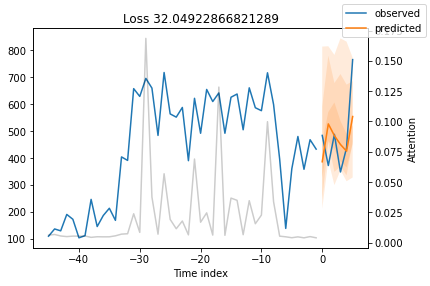

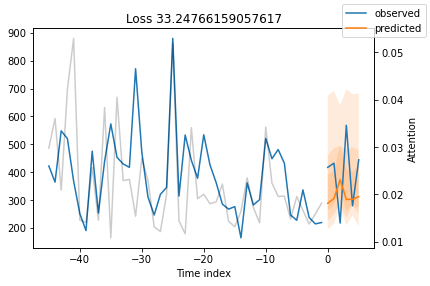

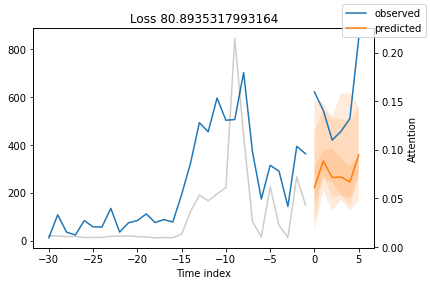

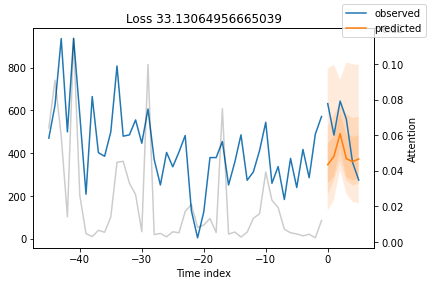

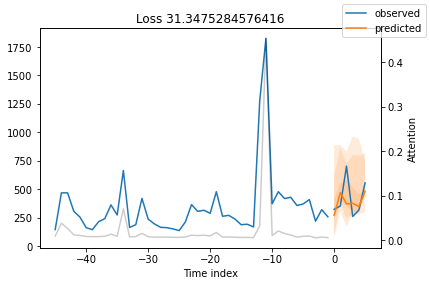

In [29]:
for idx in range(5):  # plot 10 examples
    best_tft_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

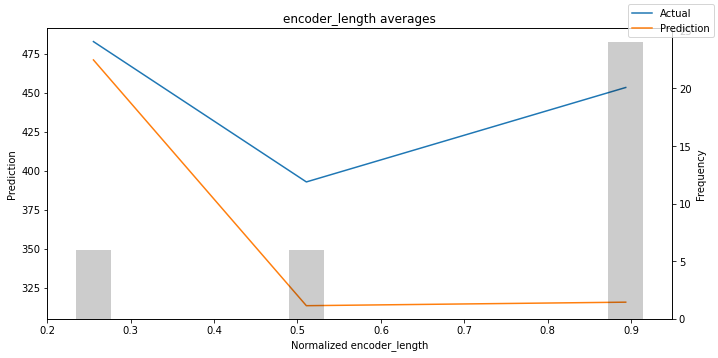

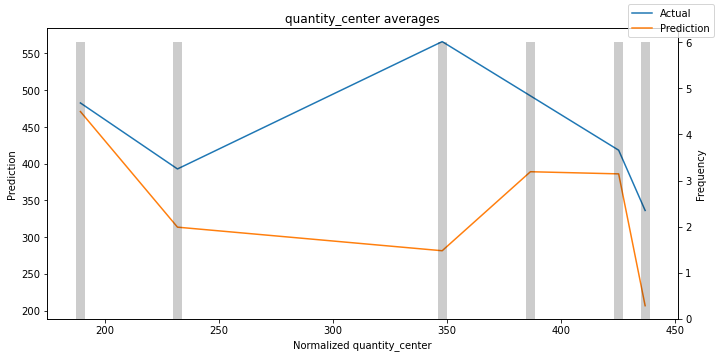

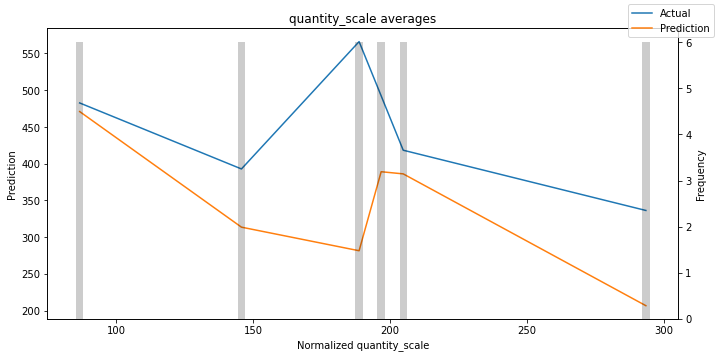

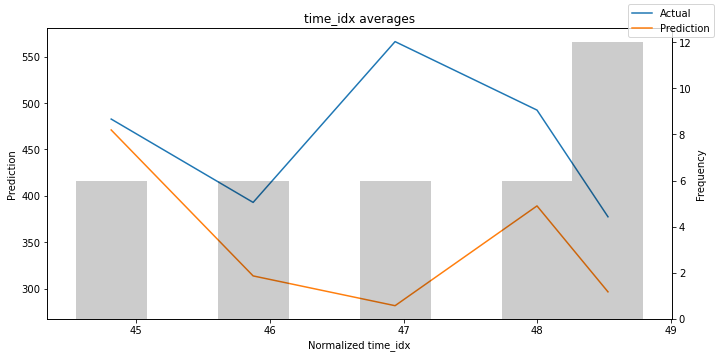

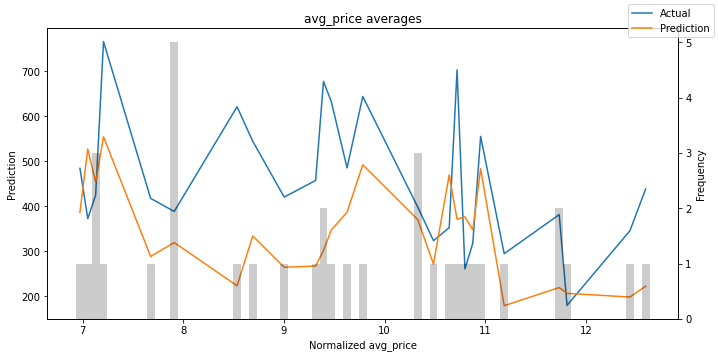

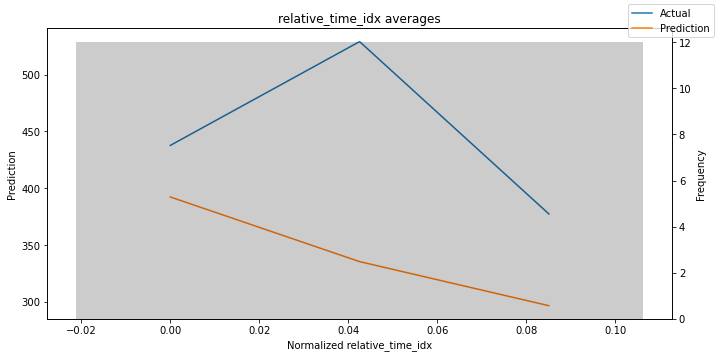

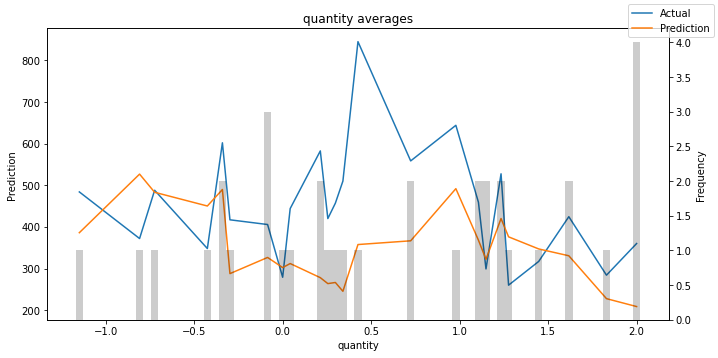

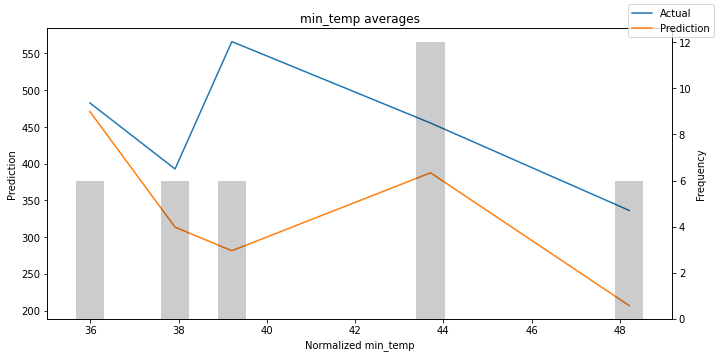

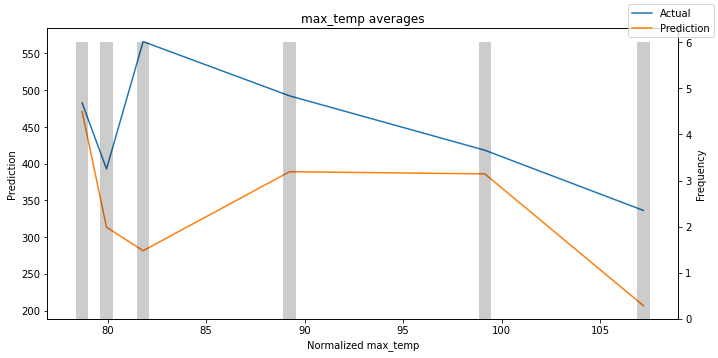

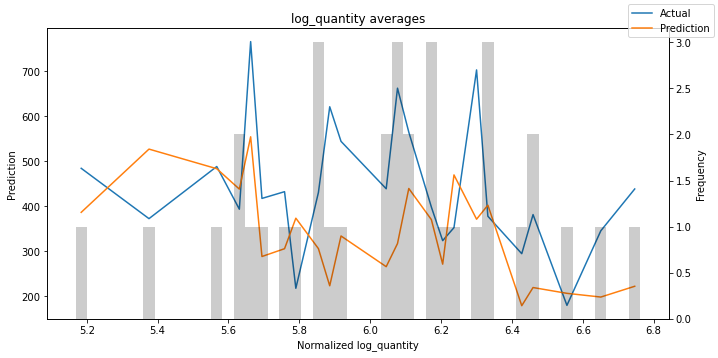

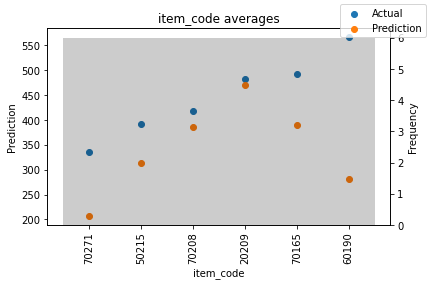

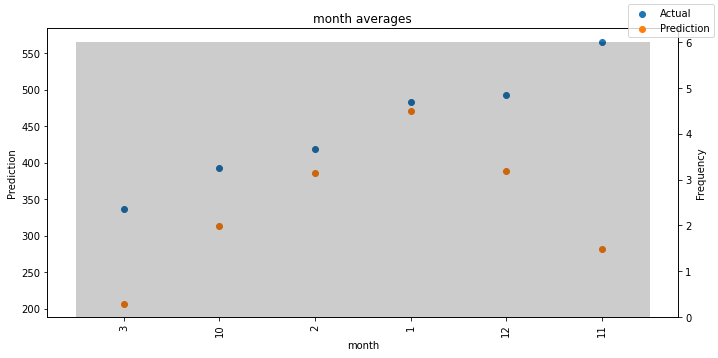

In [30]:
predictions, x = best_tft_model.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft_model.calculate_prediction_actual_by_variable(x, predictions)
best_tft_model.plot_prediction_actual_by_variable(predictions_vs_actuals);